rectangle no. 23 relatively changed by  0.0014 
rectangle no. 12 relatively changed by  0.0011 
rectangle no.  0 relatively changed by  0.0007 
rectangle no. 17 relatively changed by  0.0006 
rectangle no.  6 relatively changed by  0.0006 
rectangle no.  2 relatively changed by  0.0005 


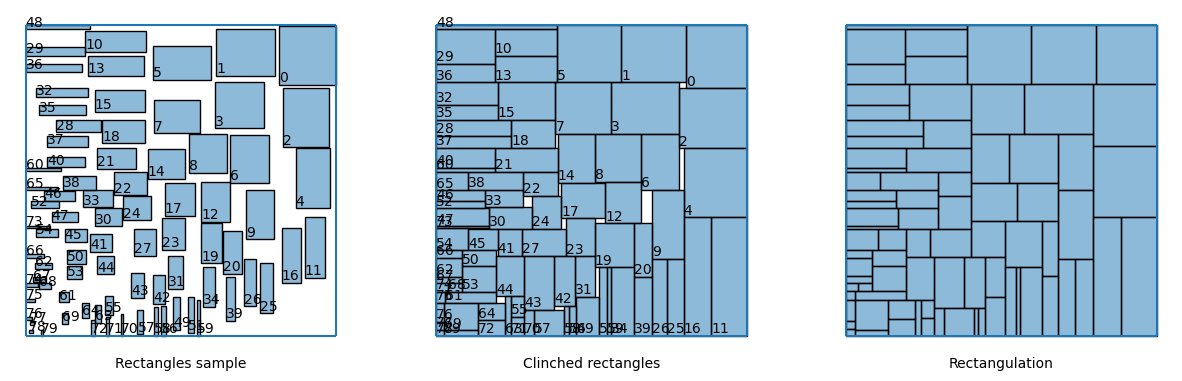

In [1]:
import numpy as np
from SquareDivision.src.rectangle_class import Rectangulation
from SquareDivision.src.distributions import FromFunction, BetweenFunctions, tepui, surface_perp_to

rects = Rectangulation(config={"seed": 123567})


width_0 = lambda mid_pt: surface_perp_to(mid_pt, vect = np.array([0, -1, 5]), val_at_0 = 0.005)
width_1 = lambda mid_pt: surface_perp_to(mid_pt, vect = np.array([0, -2, 10]), val_at_0 = 0.01)
# width_1 = lambda mid_pt: tepui(mid_pt, top=0.6, bottom=0.01, slope=2, vertex=0.8, pts=np.array([[0.5, 0.5]]))

height_0 = lambda mid_pt: surface_perp_to(mid_pt, vect = np.array([-1, 0, 5]), val_at_0 = 0.005)
height_1 = lambda mid_pt: surface_perp_to(mid_pt, vect = np.array([-2, 0, 10]), val_at_0 = 0.01)
# height_1 = lambda mid_pt: tepui(mid_pt, top=0.6, bottom=0.01, slope=2, vertex=0.6, pts=np.array([[0.5, 0.5]]))

rects.sample_rectangles(
    num=500, 
    widths_strategy = BetweenFunctions(func_0=width_0, func_1=width_1, rng=rects.rng), 
    heights_strategy= BetweenFunctions(func_0=height_0, func_1=height_1, rng=rects.rng), 
)
rects.find_disjoint_family()
rects.clinch()
rects.close_holes()

rects.report(tol=0.0005, digits=4, limit_list=20)
rects.draw(disjoint=True, inflated=True, inflated_nums=True, closed=True, closed_nums=False)

### graph f : (0, 1)^2 -> R

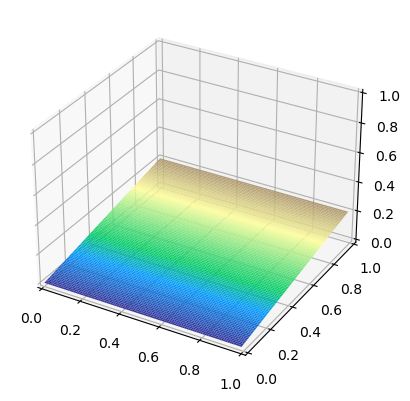

In [3]:
import numpy as np
from SquareDivision.src.distributions import surface_perp_to, tepui
from SquareDivision.draw.draw import draw_func
# mid_pt, vect = np.array([0, -1, 5]), val_at_0 = 0.005
surface_perp_to_kwargs = {'vect' : np.array([0, -1, 5]), 'val_at_0' : 0.005}
# tepui_kwargs = {
#     'top' : 0.4, 
#     'bottom' : 0.1, 
#     'slope' : 3, 
#     'vertex' : 0.7, 
#     'pts' : np.array([[0.5, 0.5]])
#     }
draw_func(surface_perp_to, func_kwargs = surface_perp_to_kwargs )
# draw_func(tepui, func_kwargs = tepui_kwargs )

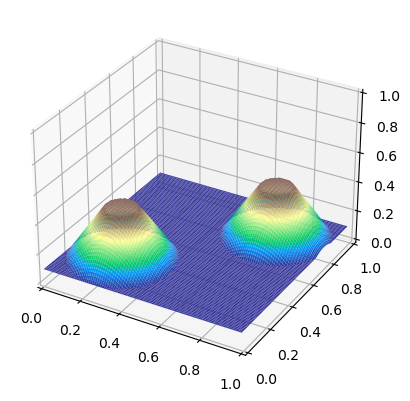

In [2]:
from SquareDivision.src.distributions import tepui
from SquareDivision.draw.draw import draw_func
tepui_kwargs = {'bottom': 0.1, 'top': 0.45, 'vertex': 0.6, 'slope': 2}
draw_func(tepui, func_kwargs = tepui_kwargs )

In [ ]:
rects.draw_contact_graph(1)

In [9]:
import numpy as np
from numpy.random._generator import Generator

def call_experiment(distribution, rng:Generator, **kwargs):
    return rng.__getattribute__(distribution)(**kwargs)
xmin, ymin, xmax, ymax = 0, 0, 1, 1
# [xmin, ymin], [xmax, ymax], size=(2, 2)
call_experiment('uniform', rects.rng, low=[0, 0], high=[1, 1], size=(2, 2))

array([[0.95186745, 0.26756241],
       [0.69207914, 0.72522422]])